In [1]:
# Imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import SubsetRandomSampler

# Images directories
train_dir = './train_images'
test_dir = './test_images'

# Normalize data -> prepare transformer
transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

# Import data and transform them
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

# Size of training / data -> 20% goes to validation
valid_size = 0.2

# When train ML, send batch by batch -> we send packages (batch) of 32 images every step
batch_size = 32

# Get index according to length, and shuffle it -> separate validation and training randomly every time
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)

# Get index used for validation by spliting array
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Sampler function
# train_sampler = SubsetRandomSampler(train_new_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

train_sampler = ImbalancedDatasetSampler(train_data, train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data, valid_idx)

# What to feed to training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

In [2]:
import torch.nn as nn
import torch.nn.functional as F
# Network, ready to use
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2, padding_mode='zeros')
        self.pool = nn.MaxPool2d(2, 2) #Pooling 2 by 2, window of 2
        self.conv2 = nn.Conv2d(32, 64, 5 , padding=2, padding_mode='zeros')
        #self.conv3 = nn.Conv2d(64, 128, 5, padding=2, padding_mode='zeros')
        self.fc1 = nn.Linear(64 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [3]:
# Network creation
net = Net()

In [4]:
# Calculate Entropy error -> test accuracy of model, we want criterion to tend to 0.
# Optimize change network each time to make it better. It's ran between every batches
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Model training

In [5]:
saved_loss = []
for epoch in range(10):  # loop over the dataset multiple times -> epoch = nb of time we go through dataset, careful with overfitting

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward (calculating via current model) + backward (learning from mistakes) + optimize (fix mistakes)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() # We want to minimize loss
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            if i == 2199:
                saved_loss.append(running_loss)
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.694
[1,   400] loss: 0.693
[1,   600] loss: 0.693
[1,   800] loss: 0.692
[1,  1000] loss: 0.692
[1,  1200] loss: 0.692
[1,  1400] loss: 0.691
[1,  1600] loss: 0.690
[1,  1800] loss: 0.689
[1,  2000] loss: 0.687
[1,  2200] loss: 0.682
[2,   200] loss: 0.653
[2,   400] loss: 0.533
[2,   600] loss: 0.280
[2,   800] loss: 0.231
[2,  1000] loss: 0.174
[2,  1200] loss: 0.167
[2,  1400] loss: 0.130
[2,  1600] loss: 0.119
[2,  1800] loss: 0.102
[2,  2000] loss: 0.114
[2,  2200] loss: 0.089
[3,   200] loss: 0.070
[3,   400] loss: 0.062
[3,   600] loss: 0.055
[3,   800] loss: 0.062
[3,  1000] loss: 0.043
[3,  1200] loss: 0.042
[3,  1400] loss: 0.040
[3,  1600] loss: 0.043
[3,  1800] loss: 0.034
[3,  2000] loss: 0.034
[3,  2200] loss: 0.031
[4,   200] loss: 0.029
[4,   400] loss: 0.032
[4,   600] loss: 0.031
[4,   800] loss: 0.026
[4,  1000] loss: 0.021
[4,  1200] loss: 0.020
[4,  1400] loss: 0.025
[4,  1600] loss: 0.022
[4,  1800] loss: 0.025
[4,  2000] loss: 0.021
[4,  2200] 

In [6]:
torch.save(net, "model_95_test.pt")

## Testing

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


## Multiple Faces Test

In [23]:
import cv2

In [64]:
torch_image

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0392]]]],
       dtype=torch.float64)

In [66]:
originalImage = cv2.imread('martin.jpg')
image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)/255.

image_tensor = s

#little_image = image[0:36, 0:36]

torch_image = torch.from_numpy(little_image).type(torch.FloatTensor)
torch_image = torch.unsqueeze(torch_image, dim=0)
torch_image = torch.unsqueeze(torch_image, dim=0)

result = net(torch_image)

In [106]:

step = 5
size = 36
whole_size = 360
nb_windows = int((whole_size - size + 1)/step)
mat = np.zeros((nb_windows,nb_windows))
cpt = 0
for i in range(nb_windows) :
    for j in range(nb_windows) :
        cpt+=1
        small_image = image[(step*i):(step*i)+size, (step*j):(step*j)+size]
        print(cpt, small_image.shape)
        torch_image = torch.from_numpy(small_image).type(torch.FloatTensor)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        torch_image = torch.unsqueeze(torch_image, dim=0)
        outputs = net(torch_image)
        _, predicted = torch.max(outputs.data, 1)
        mat[i][j] = predicted
        L.append(int(predicted))

1 (36, 36)
2 (36, 36)
3 (36, 36)
4 (36, 36)
5 (36, 36)
6 (36, 36)
7 (36, 36)
8 (36, 36)
9 (36, 36)
10 (36, 36)
11 (36, 36)
12 (36, 36)
13 (36, 36)
14 (36, 36)
15 (36, 36)
16 (36, 36)
17 (36, 36)
18 (36, 36)
19 (36, 36)
20 (36, 36)
21 (36, 36)
22 (36, 36)
23 (36, 36)
24 (36, 36)
25 (36, 36)
26 (36, 36)
27 (36, 36)
28 (36, 36)
29 (36, 36)
30 (36, 36)
31 (36, 36)
32 (36, 36)
33 (36, 36)
34 (36, 36)
35 (36, 36)
36 (36, 36)
37 (36, 36)
38 (36, 36)
39 (36, 36)
40 (36, 36)
41 (36, 36)
42 (36, 36)
43 (36, 36)
44 (36, 36)
45 (36, 36)
46 (36, 36)
47 (36, 36)
48 (36, 36)
49 (36, 36)
50 (36, 36)
51 (36, 36)
52 (36, 36)
53 (36, 36)
54 (36, 36)
55 (36, 36)
56 (36, 36)
57 (36, 36)
58 (36, 36)
59 (36, 36)
60 (36, 36)
61 (36, 36)
62 (36, 36)
63 (36, 36)
64 (36, 36)
65 (36, 36)
66 (36, 36)
67 (36, 36)
68 (36, 36)
69 (36, 36)
70 (36, 36)
71 (36, 36)
72 (36, 36)
73 (36, 36)
74 (36, 36)
75 (36, 36)
76 (36, 36)
77 (36, 36)
78 (36, 36)
79 (36, 36)
80 (36, 36)
81 (36, 36)
82 (36, 36)
83 (36, 36)
84 (36, 36)
8

655 (36, 36)
656 (36, 36)
657 (36, 36)
658 (36, 36)
659 (36, 36)
660 (36, 36)
661 (36, 36)
662 (36, 36)
663 (36, 36)
664 (36, 36)
665 (36, 36)
666 (36, 36)
667 (36, 36)
668 (36, 36)
669 (36, 36)
670 (36, 36)
671 (36, 36)
672 (36, 36)
673 (36, 36)
674 (36, 36)
675 (36, 36)
676 (36, 36)
677 (36, 36)
678 (36, 36)
679 (36, 36)
680 (36, 36)
681 (36, 36)
682 (36, 36)
683 (36, 36)
684 (36, 36)
685 (36, 36)
686 (36, 36)
687 (36, 36)
688 (36, 36)
689 (36, 36)
690 (36, 36)
691 (36, 36)
692 (36, 36)
693 (36, 36)
694 (36, 36)
695 (36, 36)
696 (36, 36)
697 (36, 36)
698 (36, 36)
699 (36, 36)
700 (36, 36)
701 (36, 36)
702 (36, 36)
703 (36, 36)
704 (36, 36)
705 (36, 36)
706 (36, 36)
707 (36, 36)
708 (36, 36)
709 (36, 36)
710 (36, 36)
711 (36, 36)
712 (36, 36)
713 (36, 36)
714 (36, 36)
715 (36, 36)
716 (36, 36)
717 (36, 36)
718 (36, 36)
719 (36, 36)
720 (36, 36)
721 (36, 36)
722 (36, 36)
723 (36, 36)
724 (36, 36)
725 (36, 36)
726 (36, 36)
727 (36, 36)
728 (36, 36)
729 (36, 36)
730 (36, 36)
731 (36, 36)

1316 (36, 36)
1317 (36, 36)
1318 (36, 36)
1319 (36, 36)
1320 (36, 36)
1321 (36, 36)
1322 (36, 36)
1323 (36, 36)
1324 (36, 36)
1325 (36, 36)
1326 (36, 36)
1327 (36, 36)
1328 (36, 36)
1329 (36, 36)
1330 (36, 36)
1331 (36, 36)
1332 (36, 36)
1333 (36, 36)
1334 (36, 36)
1335 (36, 36)
1336 (36, 36)
1337 (36, 36)
1338 (36, 36)
1339 (36, 36)
1340 (36, 36)
1341 (36, 36)
1342 (36, 36)
1343 (36, 36)
1344 (36, 36)
1345 (36, 36)
1346 (36, 36)
1347 (36, 36)
1348 (36, 36)
1349 (36, 36)
1350 (36, 36)
1351 (36, 36)
1352 (36, 36)
1353 (36, 36)
1354 (36, 36)
1355 (36, 36)
1356 (36, 36)
1357 (36, 36)
1358 (36, 36)
1359 (36, 36)
1360 (36, 36)
1361 (36, 36)
1362 (36, 36)
1363 (36, 36)
1364 (36, 36)
1365 (36, 36)
1366 (36, 36)
1367 (36, 36)
1368 (36, 36)
1369 (36, 36)
1370 (36, 36)
1371 (36, 36)
1372 (36, 36)
1373 (36, 36)
1374 (36, 36)
1375 (36, 36)
1376 (36, 36)
1377 (36, 36)
1378 (36, 36)
1379 (36, 36)
1380 (36, 36)
1381 (36, 36)
1382 (36, 36)
1383 (36, 36)
1384 (36, 36)
1385 (36, 36)
1386 (36, 36)
1387 (

1951 (36, 36)
1952 (36, 36)
1953 (36, 36)
1954 (36, 36)
1955 (36, 36)
1956 (36, 36)
1957 (36, 36)
1958 (36, 36)
1959 (36, 36)
1960 (36, 36)
1961 (36, 36)
1962 (36, 36)
1963 (36, 36)
1964 (36, 36)
1965 (36, 36)
1966 (36, 36)
1967 (36, 36)
1968 (36, 36)
1969 (36, 36)
1970 (36, 36)
1971 (36, 36)
1972 (36, 36)
1973 (36, 36)
1974 (36, 36)
1975 (36, 36)
1976 (36, 36)
1977 (36, 36)
1978 (36, 36)
1979 (36, 36)
1980 (36, 36)
1981 (36, 36)
1982 (36, 36)
1983 (36, 36)
1984 (36, 36)
1985 (36, 36)
1986 (36, 36)
1987 (36, 36)
1988 (36, 36)
1989 (36, 36)
1990 (36, 36)
1991 (36, 36)
1992 (36, 36)
1993 (36, 36)
1994 (36, 36)
1995 (36, 36)
1996 (36, 36)
1997 (36, 36)
1998 (36, 36)
1999 (36, 36)
2000 (36, 36)
2001 (36, 36)
2002 (36, 36)
2003 (36, 36)
2004 (36, 36)
2005 (36, 36)
2006 (36, 36)
2007 (36, 36)
2008 (36, 36)
2009 (36, 36)
2010 (36, 36)
2011 (36, 36)
2012 (36, 36)
2013 (36, 36)
2014 (36, 36)
2015 (36, 36)
2016 (36, 36)
2017 (36, 36)
2018 (36, 36)
2019 (36, 36)
2020 (36, 36)
2021 (36, 36)
2022 (

2586 (36, 36)
2587 (36, 36)
2588 (36, 36)
2589 (36, 36)
2590 (36, 36)
2591 (36, 36)
2592 (36, 36)
2593 (36, 36)
2594 (36, 36)
2595 (36, 36)
2596 (36, 36)
2597 (36, 36)
2598 (36, 36)
2599 (36, 36)
2600 (36, 36)
2601 (36, 36)
2602 (36, 36)
2603 (36, 36)
2604 (36, 36)
2605 (36, 36)
2606 (36, 36)
2607 (36, 36)
2608 (36, 36)
2609 (36, 36)
2610 (36, 36)
2611 (36, 36)
2612 (36, 36)
2613 (36, 36)
2614 (36, 36)
2615 (36, 36)
2616 (36, 36)
2617 (36, 36)
2618 (36, 36)
2619 (36, 36)
2620 (36, 36)
2621 (36, 36)
2622 (36, 36)
2623 (36, 36)
2624 (36, 36)
2625 (36, 36)
2626 (36, 36)
2627 (36, 36)
2628 (36, 36)
2629 (36, 36)
2630 (36, 36)
2631 (36, 36)
2632 (36, 36)
2633 (36, 36)
2634 (36, 36)
2635 (36, 36)
2636 (36, 36)
2637 (36, 36)
2638 (36, 36)
2639 (36, 36)
2640 (36, 36)
2641 (36, 36)
2642 (36, 36)
2643 (36, 36)
2644 (36, 36)
2645 (36, 36)
2646 (36, 36)
2647 (36, 36)
2648 (36, 36)
2649 (36, 36)
2650 (36, 36)
2651 (36, 36)
2652 (36, 36)
2653 (36, 36)
2654 (36, 36)
2655 (36, 36)
2656 (36, 36)
2657 (

3229 (36, 36)
3230 (36, 36)
3231 (36, 36)
3232 (36, 36)
3233 (36, 36)
3234 (36, 36)
3235 (36, 36)
3236 (36, 36)
3237 (36, 36)
3238 (36, 36)
3239 (36, 36)
3240 (36, 36)
3241 (36, 36)
3242 (36, 36)
3243 (36, 36)
3244 (36, 36)
3245 (36, 36)
3246 (36, 36)
3247 (36, 36)
3248 (36, 36)
3249 (36, 36)
3250 (36, 36)
3251 (36, 36)
3252 (36, 36)
3253 (36, 36)
3254 (36, 36)
3255 (36, 36)
3256 (36, 36)
3257 (36, 36)
3258 (36, 36)
3259 (36, 36)
3260 (36, 36)
3261 (36, 36)
3262 (36, 36)
3263 (36, 36)
3264 (36, 36)
3265 (36, 36)
3266 (36, 36)
3267 (36, 36)
3268 (36, 36)
3269 (36, 36)
3270 (36, 36)
3271 (36, 36)
3272 (36, 36)
3273 (36, 36)
3274 (36, 36)
3275 (36, 36)
3276 (36, 36)
3277 (36, 36)
3278 (36, 36)
3279 (36, 36)
3280 (36, 36)
3281 (36, 36)
3282 (36, 36)
3283 (36, 36)
3284 (36, 36)
3285 (36, 36)
3286 (36, 36)
3287 (36, 36)
3288 (36, 36)
3289 (36, 36)
3290 (36, 36)
3291 (36, 36)
3292 (36, 36)
3293 (36, 36)
3294 (36, 36)
3295 (36, 36)
3296 (36, 36)
3297 (36, 36)
3298 (36, 36)
3299 (36, 36)
3300 (

3899 (36, 36)
3900 (36, 36)
3901 (36, 36)
3902 (36, 36)
3903 (36, 36)
3904 (36, 36)
3905 (36, 36)
3906 (36, 36)
3907 (36, 36)
3908 (36, 36)
3909 (36, 36)
3910 (36, 36)
3911 (36, 36)
3912 (36, 36)
3913 (36, 36)
3914 (36, 36)
3915 (36, 36)
3916 (36, 36)
3917 (36, 36)
3918 (36, 36)
3919 (36, 36)
3920 (36, 36)
3921 (36, 36)
3922 (36, 36)
3923 (36, 36)
3924 (36, 36)
3925 (36, 36)
3926 (36, 36)
3927 (36, 36)
3928 (36, 36)
3929 (36, 36)
3930 (36, 36)
3931 (36, 36)
3932 (36, 36)
3933 (36, 36)
3934 (36, 36)
3935 (36, 36)
3936 (36, 36)
3937 (36, 36)
3938 (36, 36)
3939 (36, 36)
3940 (36, 36)
3941 (36, 36)
3942 (36, 36)
3943 (36, 36)
3944 (36, 36)
3945 (36, 36)
3946 (36, 36)
3947 (36, 36)
3948 (36, 36)
3949 (36, 36)
3950 (36, 36)
3951 (36, 36)
3952 (36, 36)
3953 (36, 36)
3954 (36, 36)
3955 (36, 36)
3956 (36, 36)
3957 (36, 36)
3958 (36, 36)
3959 (36, 36)
3960 (36, 36)
3961 (36, 36)
3962 (36, 36)
3963 (36, 36)
3964 (36, 36)
3965 (36, 36)
3966 (36, 36)
3967 (36, 36)
3968 (36, 36)
3969 (36, 36)
3970 (

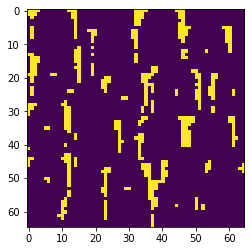

In [114]:
import matplotlib.pyplot as plt
plt.imshow(mat)

In [38]:
# loop over the image pyramid
for resized in image :
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
        # WINDOW
        # since we do not have a classifier, we'll just draw the window
        clone = resized.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window", clone)
        cv2.waitKey(1)
        time.sleep(0.025)

NameError: name 'sliding_window' is not defined

In [ ]:
inputs, classes = next(iter(test_loader))   

In [43]:
import matplotlib.pyplot as plt

In [44]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [46]:
image_tensor.shape

torch.Size([3, 36, 36])

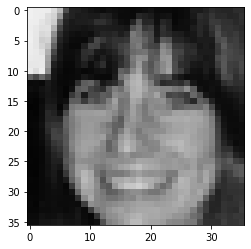

In [45]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

image_tensor = torchvision.utils.make_grid(images[0])
image_label = labels[0]

# show images
imshow(image_tensor)


In [ ]:
labels[0]

### Printing loss according to epoch, to find best model and avoid overfitting

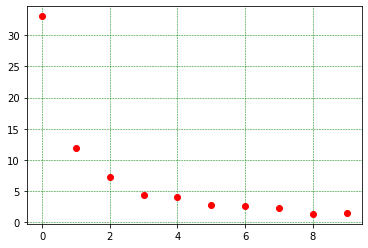

In [38]:

# X axis parameter:
xaxis = range(0, 10)

# Y axis parameter:
yaxis = saved_loss 

plt.plot(xaxis, yaxis, 'ro')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()